In [ ]:
# DCGAN
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import gzip
import random
import os
from scipy.io import loadmat
import scipy

import warnings
warnings.simplefilter('ignore')

In [ ]:
print(tf.__version__)

2.4.0


In [ ]:
# シード値の固定
def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

In [ ]:
# Street View Housing Data Set のダウンロード http://ufldl.stanford.edu/housenumbers/
# test_32x32.matの自動ダウンロードに失敗するときは、URLから直接ダウンロード

if os.path.isfile('train_32x32.mat') & os.path.isfile('test_32x32.mat'):
    pass
else:
    url_train_data = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
    url_test_data = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
    train_filename = url_train_data.split('/')[-1]
    test_filename = url_test_data.split('/')[-1]

    r_train = requests.get(url_train_data, stream=True)
    r_test = requests.get(url_test_data, stream=True)

    with open(train_filename, 'wb') as f:
        for chunk in r_train.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                f.flush()

    with open(test_filename, 'wb') as f:
        for chunk in r_test.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                f.flush()

In [ ]:
trainset = loadmat('train_32x32.mat')
testset = loadmat('test_32x32.mat')

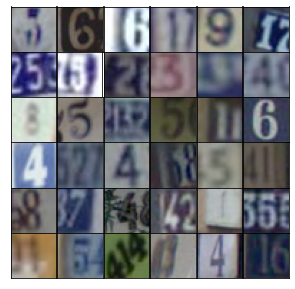

In [ ]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii,ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
# データのスケールを揃える

def scale(x, feature_ranges=(-1,1)):
    x = ((x - x.min())/ (255 - x.min()))
    
    min, max = feature_ranges
    x = x * (max - min) + min
    return x

In [ ]:
# Datasetのクラスを定義する
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_index = int(len(test['y']) * (1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_index], test['X'][:,:,:,split_index:]
        self.test_y, self.valid_y = test['y'][:split_index], test['y'][split_index:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
            
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

In [ ]:
# 変数（プレースホルダー）を初期化する関数
def model_inputs(real_dim, z_dim):
    inputs_real = tf.compat.v1.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.compat.v1.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [ ]:
# ジェネレーターを定義しよう

def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.compat.v1.variable_scope('generator', reuse=reuse):
        x1 = tf.compat.v1.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.compat.v1.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.compat.v1.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.compat.v1.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.compat.v1.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.compat.v1.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128
        
        logits = tf.compat.v1.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3
        
        out = tf.tanh(logits)
        
        return out

In [ ]:
# ディスクリミネーターを定義しよう
def discriminator(x, reuse=False, alpha=0.2):
    with tf.compat.v1.variable_scope('discriminator', reuse=reuse):
        x1 = tf.compat.v1.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16 x 16 x64
        
        x2 = tf.compat.v1.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.compat.v1.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.compat.v1.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3= tf.compat.v1.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.compat.v1.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


In [ ]:
# 損失関数を定義しよう
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

In [ ]:
# 最適化処理を定義しよう

def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars =  tf.compat.v1.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with  tf.compat.v1.control_dependencies( tf.compat.v1.get_collection( tf.compat.v1.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

In [ ]:
# モデルのテンプレート（クラス）を定義しよう

class GAN:
    def __init__(self,real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.compat.v1.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha) # ####
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)      

In [ ]:
# 生成した画像を表示する関数の定義

def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols,sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box') # box-forced'
        im = ax.imshow(img, aspect='equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes

In [ ]:
# トレーニングの関数を定義しよう

def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.compat.v1.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    samples, losses = [], []
    steps = 0
    
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z}) 
                    
                    print("Epoch {}/{}: ".format(e+1, epochs),
                         "Discriminator Loss: {:.4f}  ".format(train_loss_d),
                         "Generator Loss: {:.4f}  ".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(generator(net.input_z, 3, reuse=True, training=False),
                                          feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()
                    
        saver.save(sess, './checkpoints/generator.ckpt')
        
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    return losses, samples

In [ ]:
# ハイパーパラメータの初期化とトレーニングの実行

real_size =  (32, 32, 3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

tf.compat.v1.disable_eager_execution()
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

In [ ]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10, 5))

Epoch 1/25:  Discriminator Loss: 2.0711   Generator Loss: 0.5505  
Epoch 1/25:  Discriminator Loss: 0.5006   Generator Loss: 1.9130  
Epoch 1/25:  Discriminator Loss: 0.0804   Generator Loss: 3.1938  
Epoch 1/25:  Discriminator Loss: 0.1995   Generator Loss: 2.0778  
Epoch 1/25:  Discriminator Loss: 0.1668   Generator Loss: 5.4163  
Epoch 1/25:  Discriminator Loss: 0.0171   Generator Loss: 5.0469  


KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title('Training Loss')
plt.legend()